# Predicting MPG with SDC

**Author:** Richard Hemphill<br>
**ID:** 903877709<br>
**Class:** ECE5268 Theory of Neural Networks<br>
**Instructor:** Dr. Georgios C. Anagnostopoulos<br>
**Description:** Utilize characteristics from various cars to predict miles-per-gallon fuel consumption.  The prediction equation is determined using Stocastic Gradient Descent minimization method.

In [97]:
# CONSTANTS
DATASET_FILE = 'autompg_dataset.csv'
NUMBER_FOR_TRAINING = 200
NUMBER_FOR_VALIDATION = 100
OUTPUT_FEATURE='mpg'
INPUT_FEATURES=['horsepower', 'weight']
EPOCHS = 1000

In [98]:
# LIBRARIES
import numpy as np                  # matrix manipulation
import random                       # shuffle data
import matplotlib.pyplot as plt     # surface plot

In [99]:
# FUNCTIONS
# Create Augmented Design Matrix
def AugmentedDesignMatrix(dataSet, features):
    # Create the design matrix.
    adm = dataSet[features[0]]
    for feature in features[1:]:
        adm = np.column_stack((adm,dataSet[feature]))
     # Augment the design matrix to accomodate the bias term.
    adm = np.column_stack((adm,np.ones(len(adm))))
    return adm

In [100]:
# Calculate Mean Squared Error
def MSE(actual, predicted):
    return np.square(np.subtract(actual, predicted)).mean()

In [101]:
def PredictionEquation(y, xs, w):
    eq = '{} = '.format(y)
    wfmat = lambda i: ('+' if i > 0 else '') + '{:0.6}'.format(i)
    for idx, x in enumerate(xs):
        eq = eq + '{}*{}'.format(wfmat(w[idx]), x)
    eq = eq + wfmat(w[-1])
    return eq

In [102]:
def StochasticGradientDecent(trainSet, outParam, inParam, epochs=100,batchSize=1,lrMax=0.1, decay=1):
    Ytrain = trainSet[outParam]
    Xtrain = AugmentedDesignMatrix(dataSet=trainSet,features=inParam)
    Wa = np.zeros(len(inParam)+1)

    iters = round(len(trainSet)/batchSize)
    msePerEpoch = []

    for e in range(epochs):
        for i in range(iters):
            batch = dataSet[batchSize*i:batchSize*(i+1)]
            Ybatch = batch[outParam]
            Xbatch = AugmentedDesignMatrix(dataSet=batch,features=inParam)
            Ypred = Xbatch.dot(Wa)
            lr = lrMax / (1 + (decay * i))
            Wa = Wa - lr * (2/batchSize) * Xbatch.T.dot(Ypred-Ybatch)

        msePerEpoch.append(MSE(Ytrain,Xtrain.dot(Wa)))

    return Wa, msePerEpoch

In [103]:
# Load data file
csvFile = open(DATASET_FILE, 'r')
dataSet = np.genfromtxt(csvFile, delimiter=',', names=True, case_sensitive=True)
csvFile.close()

In [104]:
# shuffle data randomly so that training will not use same sets every time.
random.shuffle(dataSet)

In [105]:
# Split the data set into groups for training, validation and test.
trainData = dataSet[:NUMBER_FOR_TRAINING]
valData = dataSet[NUMBER_FOR_TRAINING+1:NUMBER_FOR_TRAINING+NUMBER_FOR_VALIDATION]
testData = dataSet[NUMBER_FOR_TRAINING+NUMBER_FOR_VALIDATION+1:]

## Part (a): Batch Size 1
tbd

In [106]:
Wa, msePerEpoch = StochasticGradientDecent(trainSet=trainData, outParam=OUTPUT_FEATURE, inParam=INPUT_FEATURES, epochs=1000,batchSize=1,lrMax=10^-11, decay=0.1)

In [107]:
print(PredictionEquation(y=OUTPUT_FEATURE, xs=INPUT_FEATURES, w=Wa))

mpg = -inf*horsepower-inf*weight-inf


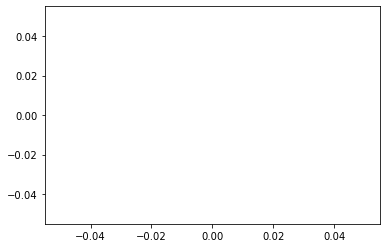

In [108]:
plt.plot(msePerEpoch)